# 躍度最小モデル
躍度最小モデル (minimum-jerk model; {cite:p}`Flash1985-vj`)を実装する．解析的に求まるが以下では二次計画法を用いて数値的に求める．

## 等式制約下の二次計画法 (Equality Constrained Quadratic Programming)

$n$個の変数があり，$m$個の制約条件がある等式制約下の二次計画問題を考える．$\mathbf {x}\in \mathbb{R}^n$, 対称行列$\mathbf{P}\in \mathbb{R}^{n\times n}$,  $\mathbf {q}\in \mathbb{R}^{n}$, $\mathbf{A}\in \mathbb{R}^{m\times n}$, $\mathbf {b}\in \mathbb{R}^m$．このとき，問題は次のようになる．

$$
\begin{align}
&{\text{Minimize}}\quad {\frac {1}{2}}\mathbf {x}^\top \mathbf{P}\mathbf {x} +\mathbf {q} ^{\top}\mathbf {x}\\
&{\text{subject to}}\quad \mathbf{A}\mathbf {x} =\mathbf {b}
\end{align}
$$

Lagrangeの未定乗数法を用いると解は

$$
\begin{equation}
{\begin{bmatrix}\mathbf{P}&\mathbf{A}^\top\\\mathbf{A}&\mathbf{0}\end{bmatrix}}{\begin{bmatrix}\mathbf {x} \\
\lambda \end{bmatrix}}={\begin{bmatrix}-\mathbf {q} \\\mathbf {b} \end{bmatrix}}
\end{equation}
$$

の解として与えられる．ここで $\lambda \in \mathbb{R}^{m}$  はLagrange乗数のベクトルである．

In [1]:
using LinearAlgebra, Random, ToeplitzMatrices, PyPlot
rc("axes.spines", top=false, right=false)
rc("font", family="Arial")

In [2]:
# Equality Constrained Quadratic Programming
function quadprog(P, q, A, b)
    """
    minimize   : 1/2 * x'*P*x + q'*x
    subject to : A*x = b
    """
    K = [P A'; A zeros(size(A)[1], size(A)[1])] # KKT matrix
    sol = K \ [-q; b] 
    return sol[1:size(A)[2]]
end

quadprog (generic function with 1 method)

計算の安定性からjuliaでは $Ax=b$の解を出すとき，`x=A^-1 * b`よりも`x=A \ b`とした方がよい．

In [3]:
P = diagm([1.0, 0.0])
q = [3.0, 4.0]
A = [1.0, 1.0]'
b = [1.0]
x = quadprog(P, q, A, b);

In [4]:
x

2-element Vector{Float64}:
 1.0
 0.0

## 躍度最小モデルの実装
1次元における運動を考えよう．この仮定ではサッカードするときの眼球運動などが当てはまる．以下では {cite:p}`Yazdani2012-sx` での問題設定を用いる．Toeplitz行列を用いた実装はYazdaniらのPythonでcvxoptを用いた実装を参考にして作成した．

問題設定は以下のようにする．

$$
\begin{align}
&\underset{u(t)}{\operatorname{minimize}}\quad \|u(t)\|_2 \\
&\text{subject to} \quad \dot{\mathbf{x}}(t)=A \mathbf{x}(t)+B u(t)
\end{align}
$$

ただし，$\|\cdot\|_{2}$ は $L_{2}$ ノルムを意味し，$A=\left[\begin{array}{lll}0 & 1 & 0 \\ 0 & 0 & 1 \\ 0 & 0 & 0\end{array}\right], B=\left[\begin{array}{l}0 \\ 0 \\ 1\end{array}\right], \mathbf{x}(t)=\left[\begin{array}{l}x(t) \\ \dot{x}(t) \\ \ddot{x}(t)\end{array}\right], u(t)=\dddot x(t)$とする．すなわち，制御信号 $u(t)$ は躍度 $\dddot x(t)$ と等しいとする．

In [5]:
T = 1.0 # simulation time (sec)
dt = 1e-2 # time step (sec)
nt = Int(T/dt) # number of samples
trange = range(0, 1, length=nt); # range of time 

In [6]:
row_jerk = [[-1, 3, -3, 1]; zeros(nt-4)]
col_jerk = [-1; zeros(nt-4)];
D_jerk = Toeplitz(col_jerk, row_jerk); 
# = diagm(0 => -ones(nt-3), 1 =>3*ones(nt-3), 2=>-3*ones(nt-3), 3=>ones(nt-3))[1:end-3, :]

実際には`D_jerk`には`(1/dt)^3`を乗じるべきであるが，二次計画法の数値的な安定性のために結果の描画の際にのみ乗じる．

In [7]:
n = 6 # dims
A = zeros(n, nt)
A[1, 1] = A[2, end] = 1 # initial/final position
A[3, 1:2] = A[4, end-1:end] = [-1, 1] # initial/final velocity
A[5, 1:3] = A[6, end-2:end] = [1, -2, 1] # initial/final acceleration

b = zeros(n) # (init or final) or (pos, vel, acc) = 2*3
b[1:2] = [0, 2];     # initial/final position (m)

二次計画法を解く．

In [8]:
sol_pos = quadprog(D_jerk' * D_jerk, zeros(nt), A, b);

位置解を速度，加速度，躍度に変換する．

In [9]:
# set D_vel and D_accel
row_vel = [[-1, 1]; zeros(nt-2)]
col_vel = [-1; zeros(nt-2)]
D_vel = (1/dt) * Toeplitz(col_vel, row_vel);

row_accel = [[1,-2,1]; zeros(nt-3)] 
col_accel = [1; zeros(nt-3)]
D_accel = (1/dt)^2 * Toeplitz(col_accel, row_accel);

# compute solution of vel, accel and jerk
sol_vel = D_vel * sol_pos;
sol_accel = D_accel * sol_pos;
sol_jerk = (1/dt)^3 * D_jerk * sol_pos;
X = [sol_pos, sol_vel, sol_accel, sol_jerk]; # concat states

結果を描画する．

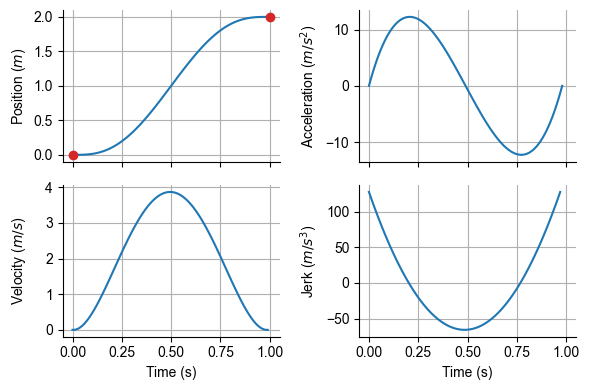

In [10]:
fig, axes = subplots(2, 2, figsize=(6,4), sharex=true)
ylabels = [L"Position ($m$)", L"Velocity ($m/s$)", L"Acceleration ($m/s^2$)", L"Jerk ($m/s^3$)"]
axf = axes[:]
for i in 1:4
    axf[i].plot(trange[1:end-(i-1)], X[i])
    axf[i].grid()
    #axf[i].set_xlim(trange[1], trange[end])
    axf[i].set_ylabel(ylabels[i])
    if i % 2 == 0
        axf[i].set_xlabel("Time (s)")
    end
end
axf[1].scatter([0, 1], b[1:2], color="tab:red", zorder=2)
fig.align_ylabels()
fig.tight_layout()

## 経由点を通る場合
経由点問題(via-point problem)を考える．

In [11]:
via_point_pos = zeros(nt)'
via_point_pos[Int(nt/2)] = 1; # via point timing

A2 = vcat(A, via_point_pos)
b2 = zeros(n+1) # (init or final) or (pos, vel, acc) + via_point_pos = 2*3 + 1 = 7 
b2[1:2] = [2, 4] # inital/final position (m)
b2[end] = 6 # via point position (m)

# compute solution of vel, accel and jerk
sol2_pos = quadprog(D_jerk' * D_jerk, zeros(nt), A2, b2);
sol2_vel = D_vel * sol2_pos;
sol2_accel = D_accel * sol2_pos;
sol2_jerk = (1/dt)^3 * D_jerk * sol2_pos;
X2 = [sol2_pos, sol2_vel, sol2_accel, sol2_jerk]; # concat states

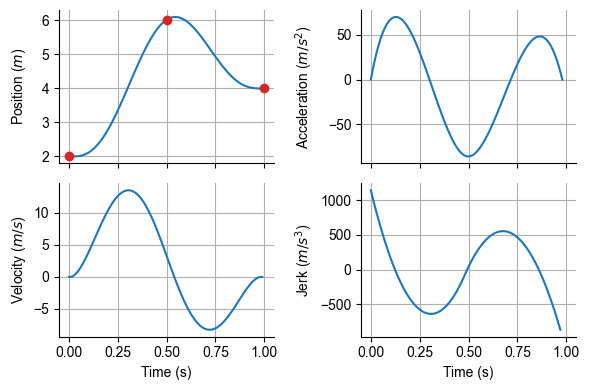

In [12]:
fig, axes = subplots(2, 2, figsize=(6,4), sharex=true)
ylabels = [L"Position ($m$)", L"Velocity ($m/s$)", L"Acceleration ($m/s^2$)", L"Jerk ($m/s^3$)"]
axf = axes[:]
for i in 1:4
    axf[i].plot(trange[1:end-(i-1)], X2[i])
    axf[i].grid()
    #axf[i].set_xlim(trange[1], trange[end])
    axf[i].set_ylabel(ylabels[i])
    if i % 2 == 0
        axf[i].set_xlabel("Time (s)")
    end
end
axf[1].scatter([0, 0.5, 1], [b2[1], b2[end], b2[2]], color="tab:red", zorder=2)
fig.align_ylabels()
fig.tight_layout()

## 参考文献
```{bibliography}
:filter: docname in docnames
```